<a href="https://www.kaggle.com/code/krist0phersmith/build-custom-cnn-for-cancer-detection?scriptVersionId=131342467" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Building CNN From Scratch With Keras For Cancer Detection
***By Kris Smith***

## Import Libraries

In [1]:
import numpy as np, pandas as pd, tensorflow as tf
import os
import cv2
from PIL import Image 
from glob import glob 
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from tensorflow.keras.models import load_model
from keras.layers.normalization import *
from keras.layers.convolutional import *
from keras.layers.core import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline


print(os.listdir("../input/histopathologic-cancer-detection"))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################################

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['sample_submission.csv', 'train_labels.csv', 'test', 'train']
Num GPUs Available:  1


---

# EDA

## Load Data

In [2]:
print(f'Total Number of Samples in Training Data = {len(os.listdir("../input/histopathologic-cancer-detection/train"))}')
print(f'Total Number of Samples in Test Data = {len(os.listdir("../input/histopathologic-cancer-detection/test"))}')

Total Number of Samples in Training Data = 220025
Total Number of Samples in Test Data = 57458


In [3]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

### Read data into pandas frames ###
## Load training and testing file names into frames
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 

## Isolate the id from file names and store as id features in seperate column
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 

## Read in training labels
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Add Labels to training data 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.sample(7)

,path,id,label
10653,../input/histopathologic-cancer-detection/trai...,5f1fed819de363ef20a20be168b8ef9641a856a1,0
200,../input/histopathologic-cancer-detection/trai...,a7a428e60387fa6f88910317c15ebe1821723589,0
135821,../input/histopathologic-cancer-detection/trai...,dd37621fb51238b4901b64df4d6248823ccf71a4,0
204292,../input/histopathologic-cancer-detection/trai...,eaa460e6c641198bf7f53ec487655cc706ee1d61,0
33623,../input/histopathologic-cancer-detection/trai...,cc502d0fb81a6d0144c0b194888146fa9f13f667,0
9063,../input/histopathologic-cancer-detection/trai...,c944a80e084418f2ec6a60dbcde833588ecbc775,1
45037,../input/histopathologic-cancer-detection/trai...,c8103baac14c3451c5fe851cc1ee56695b3daaf6,0


## Lets Inspect Distribution Among The Classes in Training Data

<AxesSubplot: title={'center': 'Class Distribution in Training Data'}>

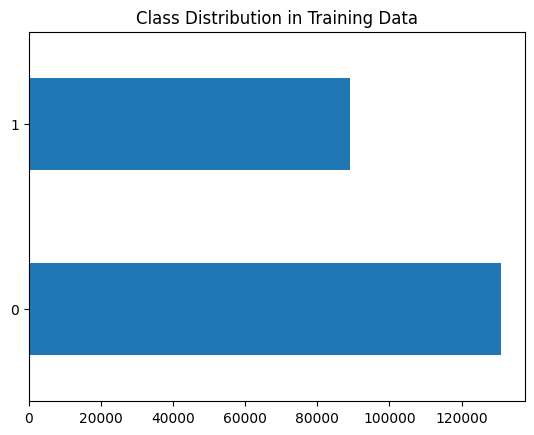

In [4]:
labels['label'].value_counts().plot(kind='barh', title='Class Distribution in Training Data')

## Inspect Some Samples From Both Positive and Negative Classes

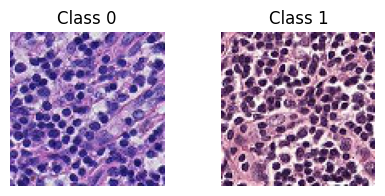

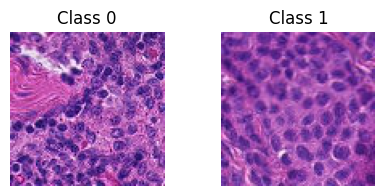

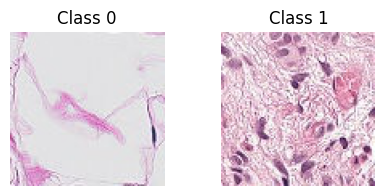

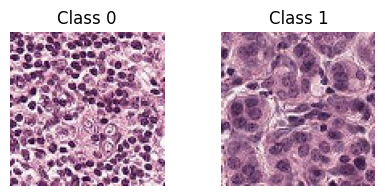

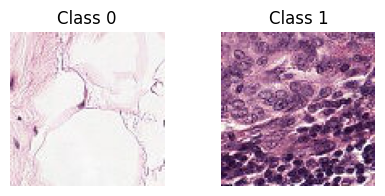

In [5]:
## Filter dataframe to get a subset of each class
class0 = df[df['label'] == 0]
class1 = df[df['label'] == 1]

for image in range(5):
    ## Select a random sample from each class
    sample0 = class0.sample(1)
    sample1 = class1.sample(1)

    ## Open image files and plot
    img_path0 = sample0['path'].values[0]
    img_path1 = sample1['path'].values[0]

    img0 = Image.open(img_path0)
    img1 = Image.open(img_path1)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))

    ax[0].imshow(img0)
    ax[0].set_title('Class 0')
    ax[0].axis('off')

    ax[1].imshow(img1)
    ax[1].set_title('Class 1')
    ax[1].axis('off')

    plt.show()

***Apparently metastatic cells should appear a different size, shape, or pattern compared to the cells around them. Inspecting these images I am realizing that I am not a medical professional and therefore I can see no obvious differences between the positive and negative class images. Therefore I will be relying on the labels and the model to distinguish between the two.***

---
# Training

## Split Training Data

In [ ]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## ImageDataGenerator method requires string data type labels
df['label'] = df['label'].astype(str)

def append_ext(ID):
    return(ID+".tif")


df["id"] = df["id"].apply(append_ext)



train_datagen = ImageDataGenerator(
       horizontal_flip=True,
       vertical_flip=True,
       #brightness_range=[0.5, 1.5],
       #fill_mode='reflect',                               
        rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2
        validation_split=0.10
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '../input/histopathologic-cancer-detection/train'
valid_path = '../input/histopathologic-cancer-detection/train'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='training',
                target_size=(96, 96),
                batch_size=16,
                class_mode='binary'
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='validation', 
                target_size=(96, 96),
                batch_size=16,
                shuffle=False,
                class_mode='binary'
                )

## Building Model Architecture

### Model 1

In [ ]:
# with tf.device('/gpu:0'):  
#     model = Sequential()
    
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size = 3))

#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size = 3))

#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size = 3))

#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Dropout(0.3))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation = 'sigmoid'))
#     model.summary()

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#     STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

#     history = model.fit(train_generator,
#                         steps_per_epoch=STEP_SIZE_TRAIN,
#                         epochs=15,
#                         validation_data=validation_generator,
#                         validation_steps=STEP_SIZE_VALID)


### Model 2

In [ ]:
with tf.device('/gpu:0'):  
    model = Sequential()
    
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID)


In [ ]:
model.evaluate_generator(generator=validation_generator)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

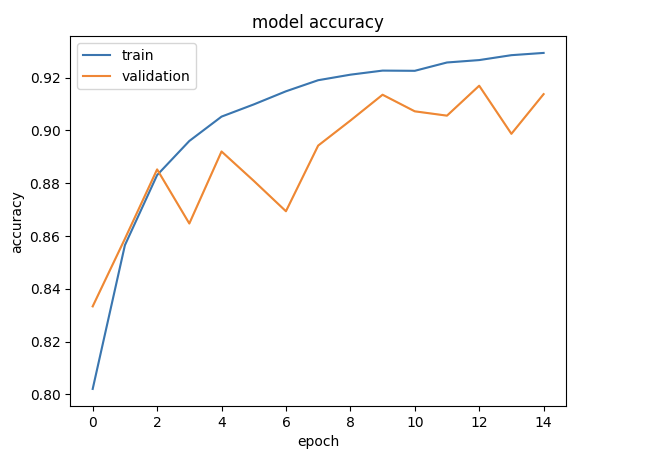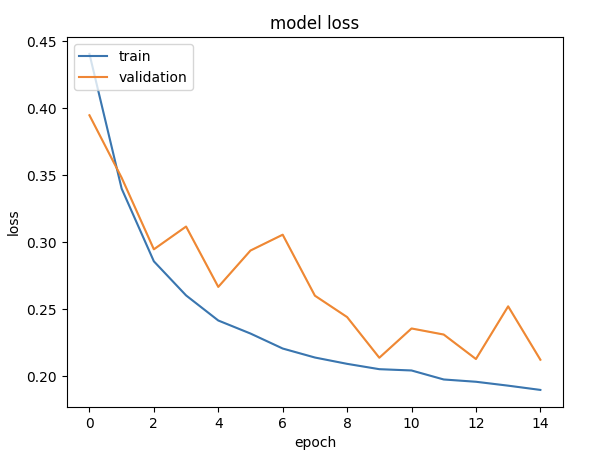

In [ ]:
# Save the model
model.save('Keras_CNN_3.h5')  

# Inference

In [ ]:
with tf.device('/GPU:0'):
#     model = load_model('/kaggle/input/cancer-detections-cnn2/Keras_CNN_1.h5')
    model = load_model('/kaggle/working/Keras_CNN_3.h5')

test_df = pd.read_csv(path + 'sample_submission.csv')

TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join(test_path,'*.tif'))
submission = pd.DataFrame()
print(len(testing_files))

for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    
    # Stack images into a batch
    images = np.stack(data_frame.image, axis=0) / 255.0
    # Predict on the entire batch
    predictions = model.predict(images).flatten()
    
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])

# Submission

In [ ]:
submission.to_csv('submission.csv', index=False, header=True)
print(len(submission))
submission.head()